In [29]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import loadtxt
import os, glob
import geopandas as gpd
import geojsonio
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import math
from IPython.display import Image

import plotly
import plotly.express as px
import chart_studio.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)
cf.go_offline()
%matplotlib inline
#pd.options.plotting.backend = "plotly"

In [30]:
# Dashboard
target="price_log"
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 100)
pd.options.display.max_seq_items = 300
pd.set_option('display.max_colwidth', 150)
sns.set(style="white")

In [31]:
# Import data_engineered
data = pd.read_pickle("saves/data_engineered.pkl")

In [32]:
# Alternative: Import from csv
#data_types_clean = pd.read_csv('saves/types_clean.csv')['types']
#data = pd.read_csv("saves/data_clean.csv", dtype=data_types_clean.to_dict())
#data.set_index('id', inplace=True)

# Data Exploration

In [33]:
# Separate/create variables for numerical and categorical features
num_features = list(data.columns[data.dtypes!=object])
cat_features = list(data.columns[data.dtypes==object])
#data_cont = data[num_features]

## Interactive Dashboards

In [34]:
# Display figures from graphical exploration below direcly here in the dashboard
@interact_manual
def show_images(file=os.listdir('data/figures/')):
    display(Image("data/figures/"+file))

interactive(children=(Dropdown(description='file', options=('3_fig1_heatmap.png', 'fig1_heatmap.png', 'fig3_ma…

In [35]:
# Display table with all rows where feature value is > x (where x is the selected threshold)
@interact(x=widgets.IntSlider(1,0,100,1,continuous_update=False))
def filter_data(column=num_features, x=10):
    return data.loc[data[column]>x]

interactive(children=(Dropdown(description='column', options=('accommodates_per_bed', 'accommodates_per_room',…

In [36]:
# Display interactive plot for comparing two features
@interact_manual(x=widgets.Dropdown(options=list(data.select_dtypes('number').columns),index=0,description="Feature"),
                 y=widgets.Dropdown(options=list(data.select_dtypes('number').columns),value=target,description="Target"),
                 kind=widgets.Dropdown(options=["bar", "box", "bubble", "heatmap", "histogram", "scatter"],value="bar",description="Plot Type"))
#                 text='title',
#                 theme=widgets.Dropdown(options=list(cf.themes.THEMES.keys()),description="Theme"),
#                 colorscale=widgets.Dropdown(options=list(cf.colors._scales_names.keys()),description="Colorscale"))


def scatter_plot(x,y, kind):#,theme,colorscale):

    data.iplot(
        kind=kind,
        x=x,
        y=y,
        mode='markers',
        xTitle=str(x),
        yTitle=str(y),
        title=f'{str(y)} vs {str(x)}')
#        text=title,
#        theme=theme,
#        colorscale=colorscale)

interactive(children=(Dropdown(description='Feature', options=('accommodates_per_bed', 'accommodates_per_room'…

## Tables (non-graphical exploration)

In [37]:
# Examine shape and head/columns of data
print(data.shape)
data.head(1)

(23623, 34)


,accommodates_per_bed,accommodates_per_room,am_balcony,am_breakfast,am_child_friendly,am_elevator,am_essentials,am_nature_and_views,am_pets_allowed,am_private_entrance,am_smoking_allowed,am_tv,am_white_goods,bathrooms_log,bedrooms,calculated_host_listings_count,cancellation_policy,host_is_superhost,instant_bookable,latitude,longitude,maximum_nights,minimum_nights_log,neighbourhood,occupancy_class,price_extra_fees_sqrt,price_extra_people,price_log,property_type,review_scores_rating_sqrt,room_type,text_len,wk_mth_discount,zipcode
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3176,2.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,strict,0,0,52.535,13.41758,1125,4.127134,Prenzlauer Berg,4,20.0,16.666667,4.382027,Apartment,6.298521,Entire home/apt,0.596687,0.23545,zip_10405


**Outliers**

**Skew**

In [38]:
# Look at data skew (to check whether scaling with e.g. log makes sense for highly skewed features)
data.skew()

accommodates_per_bed              2.571587
accommodates_per_room             3.087302
am_balcony                        1.706555
am_breakfast                      3.948022
am_child_friendly                 0.943798
am_elevator                       1.357924
am_essentials                    -3.099491
am_nature_and_views               6.033436
am_pets_allowed                   1.820483
am_private_entrance               1.827620
am_smoking_allowed                1.634282
am_tv                             0.183568
am_white_goods                   -1.882611
bathrooms_log                     2.624326
bedrooms                          2.705304
calculated_host_listings_count    6.913876
host_is_superhost                 1.841582
instant_bookable                  0.626291
latitude                         -0.091411
longitude                        -0.254334
maximum_nights                    0.391069
minimum_nights_log                1.334328
occupancy_class                   0.730374
price_extra

Based on skew, log/sqrt shall replace the original feature for:

| **FEATURE** | **METHOD** |
| :----- | :----- |
| **accommodates** | log |
| **bathrooms** | log |
| **minimum_nights** | log |
| **price** | log |
| **review_scores_rating** | sqrt |


**Correlation**

In [39]:
# Interactive feature vs. feature correlation check
@interact
def correlations(column1=list(data.select_dtypes('number').columns),
                 column2=list(data.select_dtypes('number').columns)):
    print(f"Correlation: {data[column1].corr(data[column2])}")

interactive(children=(Dropdown(description='column1', options=('accommodates_per_bed', 'accommodates_per_room'…

In [40]:
# Full list of correlation values
data.corr()

,accommodates_per_bed,accommodates_per_room,am_balcony,am_breakfast,am_child_friendly,am_elevator,am_essentials,am_nature_and_views,am_pets_allowed,am_private_entrance,am_smoking_allowed,am_tv,am_white_goods,bathrooms_log,bedrooms,calculated_host_listings_count,host_is_superhost,instant_bookable,latitude,longitude,maximum_nights,minimum_nights_log,occupancy_class,price_extra_fees_sqrt,price_extra_people,price_log,review_scores_rating_sqrt,text_len,wk_mth_discount
accommodates_per_bed,1.000000,0.374849,0.035579,0.013667,0.045957,0.033195,0.009224,0.000747,0.041747,0.031928,0.003363,0.057770,0.030255,-0.025823,-0.051757,0.040982,0.010705,0.020759,0.020426,0.021940,0.029073,-0.040671,0.039693,0.040028,0.163177,0.150155,0.012708,0.056583,-0.006494
accommodates_per_room,0.374849,1.000000,0.037702,0.003694,0.114688,0.051849,0.019496,0.010642,0.064238,0.128682,-0.046699,0.149471,-0.055177,-0.037337,-0.215147,0.191559,0.034564,0.094982,0.030425,0.010882,0.056666,-0.059722,0.144059,0.083936,0.206097,0.212435,-0.093690,0.113232,-0.023519
am_balcony,0.035579,0.037702,1.000000,-0.022517,0.081695,0.131187,0.101438,0.134202,0.023034,0.088800,-0.036265,0.126046,0.103938,0.081053,0.095261,-0.024507,0.191615,0.020479,0.021722,-0.012043,-0.032821,0.006948,0.210492,0.136321,0.105077,0.173352,0.087880,0.200511,0.007236
am_breakfast,0.013667,0.003694,-0.022517,1.000000,-0.010544,0.012491,0.043428,0.000734,0.031721,0.013464,0.031385,-0.005733,-0.001768,-0.018027,-0.015647,-0.036547,-0.022252,0.037690,0.004957,-0.016728,-0.018572,-0.054374,-0.043274,-0.030652,0.011273,0.018961,0.026134,-0.013057,-0.042432
am_child_friendly,0.045957,0.114688,0.081695,-0.010544,1.000000,0.032391,-0.006262,0.013699,0.074010,0.008421,-0.074806,0.136673,0.043224,0.073261,0.258984,0.041115,0.038090,-0.035874,0.018271,0.005128,0.004898,0.047220,0.037162,0.167865,0.129015,0.200147,-0.037568,0.152078,0.138990
am_elevator,0.033195,0.051849,0.131187,0.012491,0.032391,1.000000,0.019453,0.026998,-0.011109,0.020955,-0.031894,0.154158,0.041700,0.107097,0.039042,0.094751,0.047243,0.022088,0.044868,-0.045062,0.014790,0.036774,0.059549,0.092214,0.040575,0.183036,0.000803,0.033319,-0.008011
am_essentials,0.009224,0.019496,0.101438,0.043428,-0.006262,0.019453,1.000000,0.029702,0.022134,0.085475,-0.003017,0.021409,0.058397,0.013403,0.002788,-0.069094,0.108002,0.073813,0.017616,-0.012723,-0.035104,0.002905,0.160700,0.055323,0.044273,0.058396,0.068363,0.106133,-0.081122
am_nature_and_views,0.000747,0.010642,0.134202,0.000734,0.013699,0.026998,0.029702,1.000000,0.029058,0.057852,-0.016108,0.047239,0.009890,0.016499,0.011582,-0.004974,0.064519,0.015589,-0.027775,0.000896,-0.004714,-0.021198,0.069702,0.038058,0.040408,0.024792,0.006276,0.053537,-0.010785
am_pets_allowed,0.041747,0.064238,0.023034,0.031721,0.074010,-0.011109,0.022134,0.029058,1.000000,0.023177,0.155817,0.020449,0.023379,0.025376,0.032670,-0.009429,0.008441,0.053352,-0.034259,0.027319,-0.005022,-0.055145,0.022675,-0.034047,0.020888,0.004369,-0.041875,0.028246,-0.004946
am_private_entrance,0.031928,0.128682,0.088800,0.013464,0.008421,0.020955,0.085475,0.057852,0.023177,1.000000,-0.084385,0.140195,-0.045460,0.050017,0.101013,0.073423,0.078839,0.119774,0.000036,-0.009544,-0.015761,0.045177,0.145643,0.083001,0.047053,0.218965,0.004524,0.081337,-0.066298


## Plot visualizations (graphical exploration)

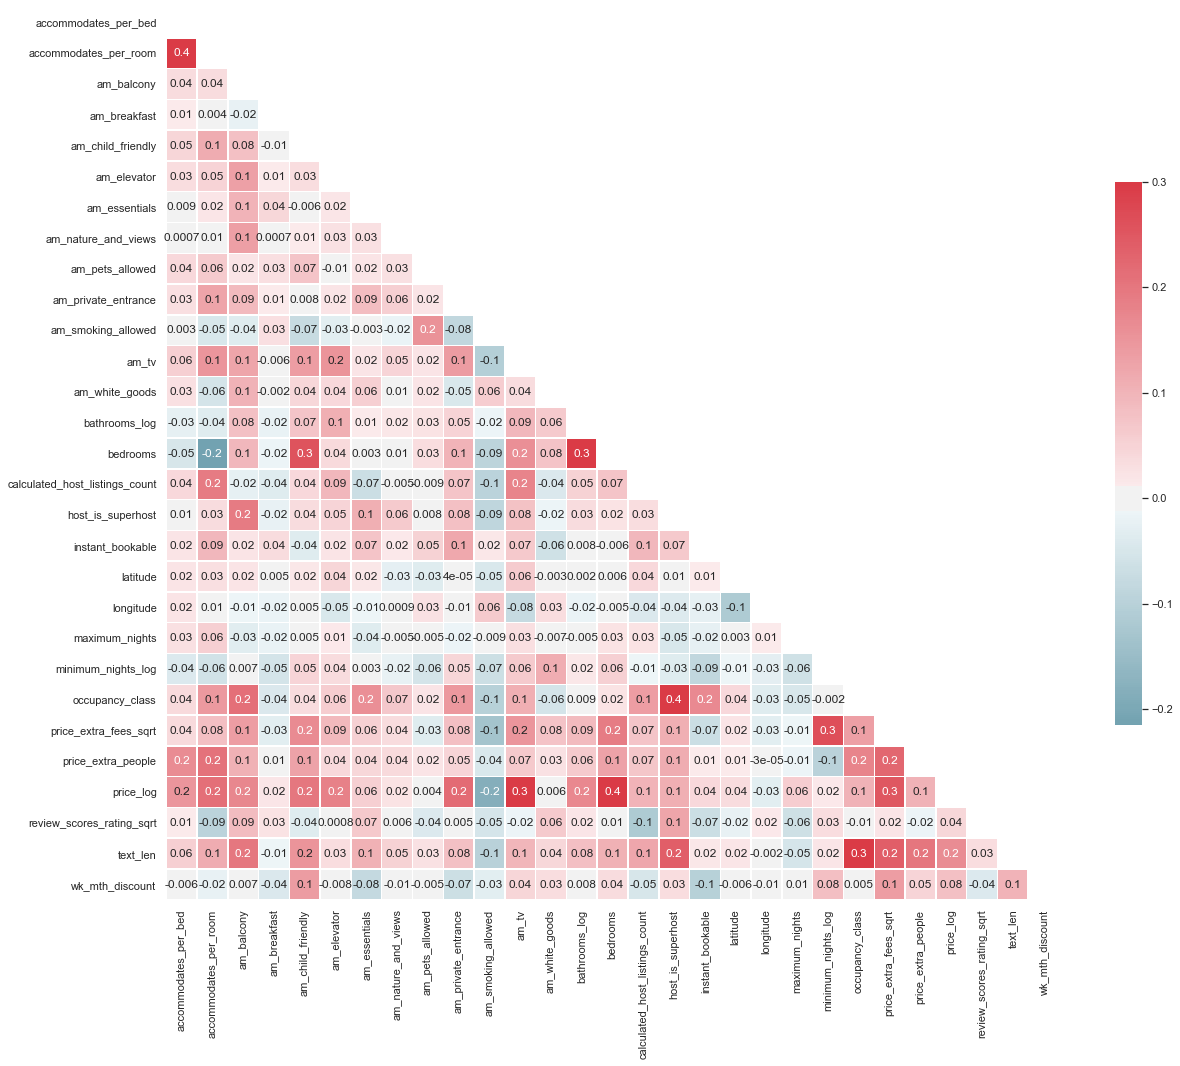

In [41]:
# Plot correlation heatmap for numerical features
#Generate a mask for the upper triangle
mask = np.triu(np.ones_like(data[num_features].corr(), dtype=np.bool))

#Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

#Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(data[num_features].corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".1g");

plt.savefig("data/figures/fig1_heatmap.png")

Highly correlated features will be removed from the analysis. For this purpose, the threshold is set at two correlations of 0.4 or above. Hence, the following features are removed:

| **FEATURE** | **REASONING** |
| :----- | :----- |
| **** |  |



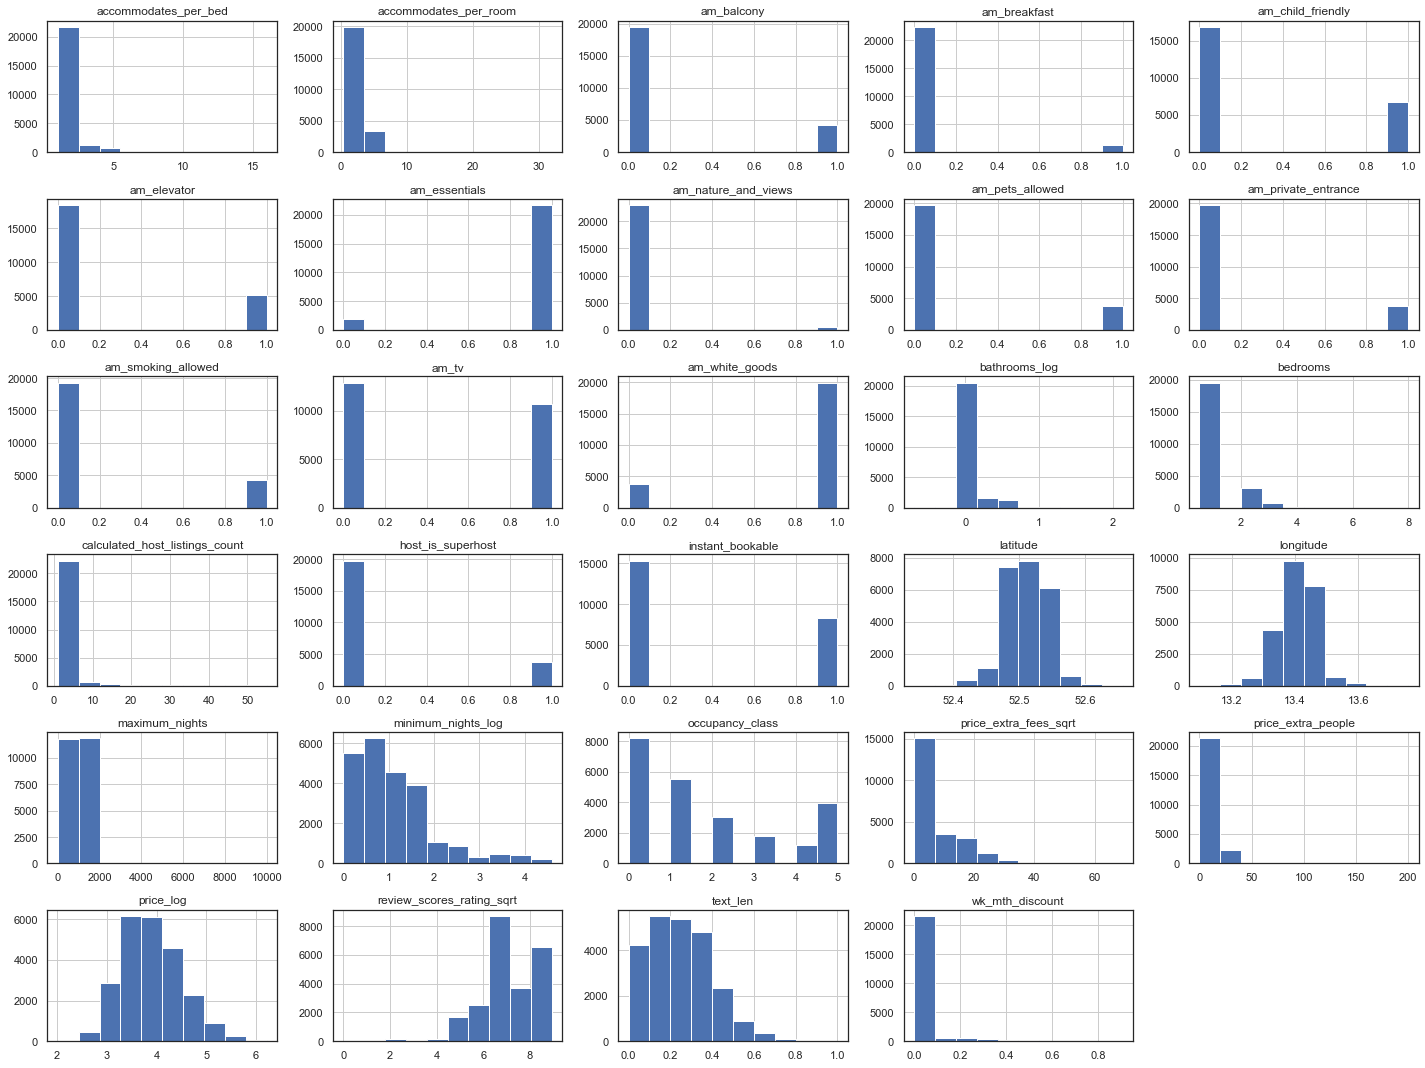

In [42]:
# Plot histogram of numerical features
data[num_features].hist(figsize=(20,15));
plt.tight_layout()